 ## Lets start with downloading necessary libraries

In [2]:
import ogb

In [18]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
import os.path as osp
import pandas as pd
import numpy as np
import collections
from pandas.core.common import flatten
# importing obg datatset
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

from pandas.core.common import flatten
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.set_theme(style="ticks")
import collections
from scipy.special import softmax
import umap

In [19]:
# download and loading the obg dataset
root = osp.join(osp.dirname(osp.realpath('./')), 'data', 'products')
dataset = PygNodePropPredDataset('ogbn-products', root)

In [20]:
root

'/mnt/d/Code/data/products'

In [21]:
# split_idx contains a dictionary of train, validation and test node indices
split_idx = dataset.get_idx_split()
# predefined ogb evaluator method used for validation of predictions
evaluator = Evaluator(name='ogbn-products')

Lets check the training, validation and test node split.

In [22]:
# lets check the node ids distribution of train, test and val
print('Number of training nodes:', split_idx['train'].size(0))
print('Number of validation nodes:', split_idx['valid'].size(0))
print('Number of test nodes:', split_idx['test'].size(0))

Number of training nodes: 196615
Number of validation nodes: 39323
Number of test nodes: 2213091


In [23]:
# loading the dataset
data = dataset[0]

1

Graph Statistics of the dataset

In [24]:
# lets check some graph statistics of ogb-product graph
print("Number of nodes in the graph:", data.num_nodes)
print("Number of edges in the graph:", data.num_edges)
print("Node feature matrix with shape:", data.x.shape) # [num_nodes, num_node_features]
print("Graph connectivity in COO format with shape:", data.edge_index.shape) # [2, num_edges]
print("Target to train against :", data.y.shape)
print("Node feature length", dataset.num_features)

Number of nodes in the graph: 2449029
Number of edges in the graph: 123718280
Node feature matrix with shape: torch.Size([2449029, 100])
Graph connectivity in COO format with shape: torch.Size([2, 123718280])
Target to train against : torch.Size([2449029, 1])
Node feature length 100


In [25]:
# checking the number of unique labels
# there are 47 unique categories of product
data.y.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [26]:
# load integer to real product category from label mapping provided inside the dataset
df = pd.read_csv('../data/products/ogbn_products/mapping/labelidx2productcategory.csv.gz')

In [27]:
# lets see some of the product categories
df[:10]

,label idx,product category
0,0,Home & Kitchen
1,1,Health & Personal Care
2,2,Beauty
3,3,Sports & Outdoors
4,4,Books
5,5,"Patio, Lawn & Garden"
6,6,Toys & Games
7,7,CDs & Vinyl
8,8,Cell Phones & Accessories
9,9,Grocery & Gourmet Food


In [28]:
# creating a dictionary of product category and corresponding integer label
label_idx, prod_cat = df.iloc[: ,0].values, df.iloc[: ,1].values
label_mapping = dict(zip(label_idx, prod_cat))


In [29]:
# counting the numbers of samples for each category
y = data.y.tolist()
y = list(flatten(y))
count_y = collections.Counter(y)
print(count_y)

Counter({4: 668950, 7: 172199, 6: 158771, 3: 151061, 12: 131886, 2: 116043, 0: 114294, 8: 110796, 1: 109832, 13: 101541, 16: 83594, 21: 80795, 9: 67358, 10: 52345, 18: 49019, 24: 45406, 17: 42337, 5: 40715, 11: 32937, 42: 32500, 15: 26911, 20: 22575, 19: 17438, 23: 3653, 14: 3079, 25: 3024, 28: 1969, 29: 1561, 43: 1399, 22: 879, 36: 630, 44: 566, 26: 553, 37: 514, 32: 513, 31: 418, 30: 277, 27: 259, 34: 154, 38: 91, 41: 61, 35: 44, 39: 37, 33: 29, 45: 9, 40: 6, 46: 1})


In [36]:
data.edge_index.T[:5]

tensor([[     0, 152857],
        [152857,      0],
        [     0,  32104],
        [ 32104,      0],
        [     0,  23158]])

In [40]:
dataset

PygNodePropPredDataset()

In [31]:
train_idx = split_idx['train']
train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[15, 10, 5], batch_size=1024,
                               shuffle=True)


# GraphSage Algorithm

In [37]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(SAGE, self).__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        layer_1_embeddings, layer_2_embeddings, layer_3_embeddings = None, None, None
        for i, (edge_index, _, size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
            xs.append(x)
            if i == 0:
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
        #return x.log_softmax(dim=-1)
        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x)

                pbar.update(batch_size)

            if i == 0:
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all

        pbar.close()

        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(dataset.num_features, 256, dataset.num_classes, num_layers=3)
model = model.to(device)

In [42]:
data.x.shape

torch.Size([2449029, 100])

In [ ]:
# loading node feature matrix and node labels
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [ ]:
def train(epoch):
    model.train()

    #pbar = tqdm(total=train_idx.size(0))
    #pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()
        l1_emb, l2_emb, l3_emb = model(x[n_id], adjs)
        #print("Layer 1 embeddings", l1_emb.shape)
        #print("Layer 2 embeddings", l1_emb.shape)
        out = l3_emb.log_softmax(dim=-1)
        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        #pbar.update(batch_size)

    #pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for epoch in range(1, 21):
    loss, acc = train(epoch)
    #print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')

In [ ]:
model

SAGE(
  (convs): ModuleList(
    (0): SAGEConv(100, 256)
    (1): SAGEConv(256, 256)
    (2): SAGEConv(256, 47)
  )
)

In [ ]:
#compute the number of trainable parameters:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_parameter = count_parameters(model)
print(total_parameter)

206895


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
convs.0.lin_l.weight 	 torch.Size([256, 100])
convs.0.lin_l.bias 	 torch.Size([256])
convs.0.lin_r.weight 	 torch.Size([256, 100])
convs.1.lin_l.weight 	 torch.Size([256, 256])
convs.1.lin_l.bias 	 torch.Size([256])
convs.1.lin_r.weight 	 torch.Size([256, 256])
convs.2.lin_l.weight 	 torch.Size([47, 256])
convs.2.lin_l.bias 	 torch.Size([47])
convs.2.lin_r.weight 	 torch.Size([47, 256])


## Saving the model for inference part

We need to save the model for the infernce part because google colab cannot create two graph loaders at the same time because of the limitation of the RAM size. Therefore, we first train with train_loader and then make inferences on test data using this saved model.

Here you can either save the model on google MyDrive or locally on your computer.


In [ ]:
#torch.save(model, '/content/drive/MyDrive/model_weights/graph_embeddings/model.pt')

# saving model in mydrive
from google.colab import drive
drive._mount('/content/drive')
fp = '/content/drive/MyDrive/model.pt'

torch.save(model, './model.pt')
torch.save(model, fp)

Mounted at /content/drive


# Inference: Let's check GraphSage Inductive Power!!


This part includes making the use of trained GraphSage model in order to compute node embeddings and performing node category prediction on test data.
Aftwerwards, we compare the <b>U-Map visualizations of node embeddings</b> at 3 different layers of GraphSage and draw some interesting observations.




## Headsup : At this point of time you need to restart the colab runtime!!!


## load the data


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.data import NeighborSampler
from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
import os.path as osp
import pandas as pd
import numpy as np
import collections
from pandas.core.common import flatten
# importing obg datatset
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from pandas.core.common import flatten
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.set_theme(style="ticks")
import collections
from scipy.special import softmax
import umap

In [ ]:
# download and loading the obg dataset
root = osp.join(osp.dirname(osp.realpath('./')), 'data', 'products')
dataset = PygNodePropPredDataset('ogbn-products', root)

This will download 1.38GB. Will you proceed? (y/N)
y


Downloaded 0.00 GB:   0%|          | 1/1414 [00:00<02:55,  8.04it/s]

Downloaded 1.38 GB: 100%|██████████| 1414/1414 [04:34<00:00,  5.15it/s]


Extracting /data/products/products.zip
Processing...
Loading necessary files...
This might take a while.



  0%|          | 0/1 [00:00<?, ?it/s]

Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 223.77it/s]


Converting graphs into PyG objects...
Saving...
Done!


In [ ]:
# split_idx contains a dictionary of train, validation and test node indices
split_idx = dataset.get_idx_split()
# predefined ogb evaluator method used for validation of predictions
evaluator = Evaluator(name='ogbn-products')

In [ ]:
# loading the dataset
data = dataset[0]

In [ ]:
subgraph_loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=1024, shuffle=False)

In [ ]:
# load integer to real product category from label mapping provided inside the dataset
df = pd.read_csv('/data/products/ogbn_products/mapping/labelidx2productcategory.csv.gz')

In [ ]:
# creating a dictionary of product category and corresponding integer label
label_idx, prod_cat = df.iloc[: ,0].values, df.iloc[: ,1].values
label_mapping = dict(zip(label_idx, prod_cat))
print("Label mapping", label_mapping)

Label mapping {0: 'Home & Kitchen', 1: 'Health & Personal Care', 2: 'Beauty', 3: 'Sports & Outdoors', 4: 'Books', 5: 'Patio, Lawn & Garden', 6: 'Toys & Games', 7: 'CDs & Vinyl', 8: 'Cell Phones & Accessories', 9: 'Grocery & Gourmet Food', 10: 'Arts, Crafts & Sewing', 11: 'Clothing, Shoes & Jewelry', 12: 'Electronics', 13: 'Movies & TV', 14: 'Software', 15: 'Video Games', 16: 'Automotive', 17: 'Pet Supplies', 18: 'Office Products', 19: 'Industrial & Scientific', 20: 'Musical Instruments', 21: 'Tools & Home Improvement', 22: 'Magazine Subscriptions', 23: 'Baby Products', 24: nan, 25: 'Appliances', 26: 'Kitchen & Dining', 27: 'Collectibles & Fine Art', 28: 'All Beauty', 29: 'Luxury Beauty', 30: 'Amazon Fashion', 31: 'Computers', 32: 'All Electronics', 33: 'Purchase Circles', 34: 'MP3 Players & Accessories', 35: 'Gift Cards', 36: 'Office & School Supplies', 37: 'Home Improvement', 38: 'Camera & Photo', 39: 'GPS & Navigation', 40: 'Digital Music', 41: 'Car Electronics', 42: 'Baby', 43: 'Kin

In [ ]:
y = data.y.tolist()
y = list(flatten(y))
count_y = collections.Counter(y)
print(count_y)

Counter({4: 668950, 7: 172199, 6: 158771, 3: 151061, 12: 131886, 2: 116043, 0: 114294, 8: 110796, 1: 109832, 13: 101541, 16: 83594, 21: 80795, 9: 67358, 10: 52345, 18: 49019, 24: 45406, 17: 42337, 5: 40715, 11: 32937, 42: 32500, 15: 26911, 20: 22575, 19: 17438, 23: 3653, 14: 3079, 25: 3024, 28: 1969, 29: 1561, 43: 1399, 22: 879, 36: 630, 44: 566, 26: 553, 37: 514, 32: 513, 31: 418, 30: 277, 27: 259, 34: 154, 38: 91, 41: 61, 35: 44, 39: 37, 33: 29, 45: 9, 40: 6, 46: 1})


## Need to define the model class again

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(SAGE, self).__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
            xs.append(x)
            if i == 0:
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
        #return x.log_softmax(dim=-1)
        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x)

                pbar.update(batch_size)

            if i == 0:
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all

        pbar.close()

        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

In [ ]:
# loading the saved model
# Load model from Drive
# from google.colab import drive
# drive._mount('/content/drive')
# fp = '/content/drive/My Drive/model.pt'
model = torch.load(fp)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# load node feature matrix and labels
x = data.x.to(device)
y = data.y.squeeze().to(device)

Perform evaluation on test data with saved model

In [ ]:
@torch.no_grad()
def test():
    model.eval()

    l1_embeddings, l2_embeddings, l3_embeddings = model.inference(x)
    out = l3_embeddings
    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return test_acc, l1_embeddings, l2_embeddings, l3_embeddings

In [ ]:
# shapes
test_acc, l1_embeddings, l2_embeddings, l3_embeddings = test()

Evaluating: 100%|██████████| 7347087/7347087 [01:49<00:00, 67363.17it/s]


In [ ]:
print('Final Test acc:', test_acc)

Final Test acc: 0.7911540917205845


## Embeddings of whole datastet layer-wise

In [ ]:
print("Layer 1 Embeddings Shape:",l1_embeddings.shape)
print("Layer 2 Embeddings Shape:",l2_embeddings.shape)
print("Layer 3 Embeddings Shape:",l3_embeddings.shape)

Layer 1 Embeddings Shape: torch.Size([2449029, 256])
Layer 2 Embeddings Shape: torch.Size([2449029, 256])
Layer 3 Embeddings Shape: torch.Size([2449029, 47])


## Embeddings of Test data layer-wise

In [ ]:
l1_embedding_test = l1_embeddings[split_idx['test']]
l2_embedding_test = l2_embeddings[split_idx['test']]
l3_embedding_test = l3_embeddings[split_idx['test']]

In [ ]:
l1_embedding_test.shape, l2_embedding_test.shape, l3_embedding_test.shape

(torch.Size([2213091, 256]),
 torch.Size([2213091, 256]),
 torch.Size([2213091, 47]))

In [ ]:
l3_embedding_smax_test = softmax(l3_embedding_test.detach().cpu().numpy(), axis=1)
l3_embedding_smax_test.shape

(2213091, 47)

In [ ]:
# saving predictions from last layer embeddings
y_pred = np.argmax(l3_embedding_smax_test, axis=1)
y_pred.shape

(2213091,)

## Embedding Visualizations with Umap

In [ ]:
reducer = umap.UMAP()

## Layer-1 Node Embeddings Visualization

In [ ]:
# sample test data
l1_emb_sample = l1_embedding_test[:2000].detach().cpu().numpy()
y_pred_sample = y_pred[:2000]
l1_emb_sample.shape, y_pred_sample.shape

((2000, 256), (2000,))

In [ ]:
y_pred_sample

array([ 2,  4,  3, ...,  9,  7, 11])

In [ ]:
# label mapping
y_pred_sample_products = []
for y in y_pred_sample:
    y_pred_sample_products.append(label_mapping[y])

y_pred_sample_products = np.array(y_pred_sample_products )


In [ ]:
# number of unique classes present in sampled data
len(set(y_pred_sample_products.tolist()))

28

In [ ]:
color_coding = ['green','yellowgreen','brown','dodgerblue','red','black', 'grey',
                'darkgreen', 'cyan', 'yellow', 'magenta', 'lightcoral', 'rosybrown', 'maroon',
                'peru', 'khaki', 'olive', 'darkseagreen', 'lightseagreen', 'lightskyblue', 'darkviolet',
                'pink', 'deeppink', 'thistle', 'ivory', 'gold', 'lavender', 'darkorange']

Now we need to train our reducer, letting it learn about the manifold. For this UMAP follows the sklearn API and has a method fit which we pass the data we want the model to learn from.



In [ ]:
l1_reduced_emb = reducer.fit_transform(l1_emb_sample)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# reduced representation
l1_reduced_emb.shape

(2000, 2)

In [ ]:
y_pred_sample_products.shape

(2000,)

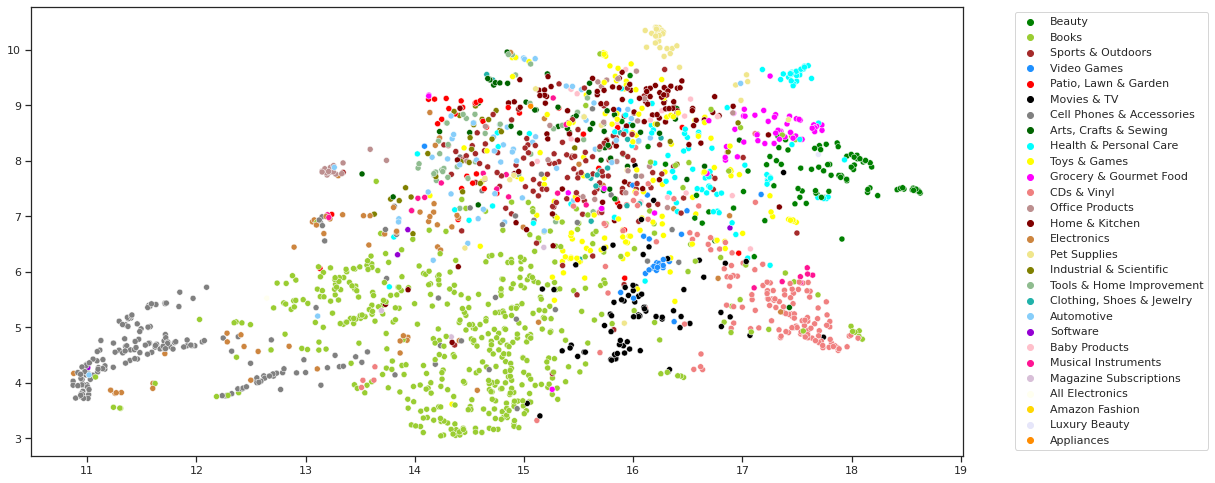

In [ ]:
# plot
sns.scatterplot(x = l1_reduced_emb[:, 0], y = l1_reduced_emb[:, 1], hue = y_pred_sample_products, palette=color_coding)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

## Observation




Node embeddings visualization at layer-1 shows that the model is not able to separate the product categories well (as the embeddings of different product categories are very close together ), therefore we cannot predict/estimate with high probability which two products can be bought together in the future or if someone buys one product then which other product he/she might also be interested.

## Layer-2 Node Embeddings Visualization

In [ ]:
# sample test data
l2_emb_sample = l2_embedding_test[:2000].detach().cpu().numpy()
y_pred_sample = y_pred[:2000]
l2_emb_sample.shape, y_pred_sample.shape

((2000, 256), (2000,))

In [ ]:
l2_reduced_emb = reducer.fit_transform(l2_emb_sample)

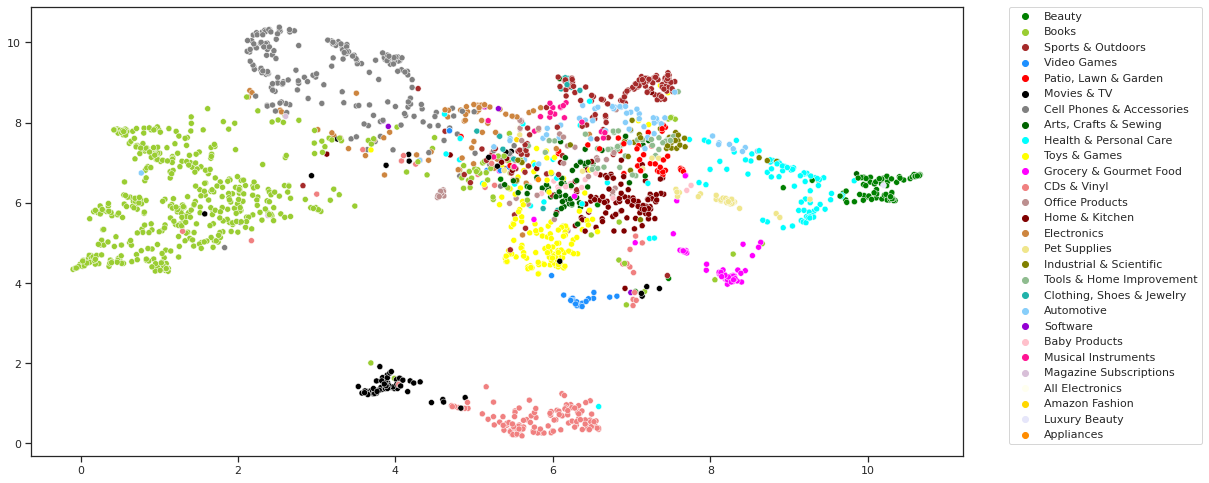

In [ ]:
# plot
sns.scatterplot(x = l2_reduced_emb[:, 0], y = l2_reduced_emb[:, 1], hue = y_pred_sample_products,  palette=color_coding)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Observation

At layer-2 we can see some separate clusters of product categories forming and we can draw some valuable insights from their for e.g.  movies&TV vs CDs&Vinyl,  Beauty vs health & personal care,  video games vs toys & games. However, books and beauty clusters are very far away from each other.

## Layer-3 Node Embeddings Visualization

In [ ]:
# sample test data
l3_emb_sample = l3_embedding_test[:2000].detach().cpu().numpy()
y_pred_sample = y_pred[:2000]
l3_emb_sample.shape, y_pred_sample.shape

((2000, 47), (2000,))

In [ ]:
l3_reduced_emb = reducer.fit_transform(l3_emb_sample)

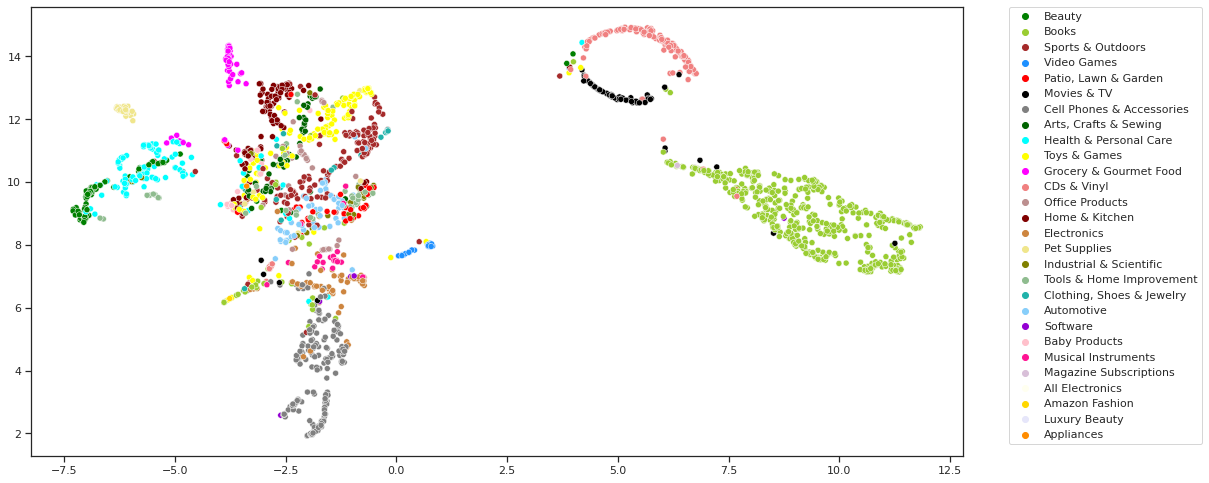

In [ ]:
# plot
sns.scatterplot(x = l3_reduced_emb[:, 0], y = l3_reduced_emb[:, 1], hue = y_pred_sample_products, palette=color_coding)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Observation

At layer-3 node representations are little more finer than the layer-2 as we can see some more distant clusters for eg. cell phones & accessories vs electronics.

# Some of the Popular GraphSage Use Cases:

1) Dynamic Graphs: These are graphs which evolve over time like social network graphs from facebook, linkedin or twitter or posts on Reddit, users and videos on Youtube.

2) Generated node embeddings via unsupervised loss function can be used for various downstream machine learning tasks like node classification, clustering, and link prediction.

3) Real-World applications which requires to compute embeddings for their subgraphs

4) Protein-Protein interaction graphs: Here, the trained embedding generator can predict the node embeddings for the data collected on new species/organisms

5) UberEats: It uses the power of Graph ML to suggest to its users the dishes, restaurants, and cuisines they might like next. To make these recommendations Uber eats uses the GraphSAGE algorithm because of its inductive nature and the power to scale up-to billion of nodes

6) Pinterest: It uses the power of PinSage (another version of GraphSage) for making visual recommendations (pins are visual bookmarks e.g. for buying clothes or other products). PinSage is a random-walk based GraphSage algorithm which learns embeddings for nodes (in billions) in web scale graphs.



# References



1. [Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216.pdf)

2. http://web.stanford.edu/class/cs224w/slides/17-scalable.pdf

3. [A Voyage through Graph Machine Learning Universe: Motivation, Applications, Datasets, Graph ML Libraries, Graph Databases](https://sachinsharma9780.medium.com/)

3. https://medium.com/pinterest-engineering/pinsage-a-new-graph-convolutional-neural-network-for-web-scale-recommender-systems-88795a107f48

4. https://eng.uber.com/uber-eats-graph-learning/

5. More stuff related to [Graph ML](https://github.com/arangodb/interactive_tutorials)




